In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class CRN(nn.Module):
    def __init__(self):
        super(CRN, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(2, 3), stride=(1, 2))
        self.bn1 = nn.BatchNorm2d(num_features=16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(2, 3), stride=(1, 2))
        self.bn2 = nn.BatchNorm2d(num_features=32)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(2, 3), stride=(1, 2))
        self.bn3 = nn.BatchNorm2d(num_features=64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(2, 3), stride=(1, 2))
        self.bn4 = nn.BatchNorm2d(num_features=128)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(2, 3), stride=(1, 2))
        self.bn5 = nn.BatchNorm2d(num_features=256)

        # LSTM
        self.LSTM1 = nn.LSTM(input_size=3584, hidden_size=3584, num_layers=1, batch_first=True)

        # Decoder
        self.convT1 = nn.ConvTranspose2d(in_channels=512, out_channels=128, kernel_size=(2, 3), stride=(1, 2), padding=(1,0))
        self.bnT1 = nn.BatchNorm2d(num_features=128)
        self.convT2 = nn.ConvTranspose2d(in_channels=256, out_channels=64, kernel_size=(2, 3), stride=(1, 2), padding=(1,0))
        self.bnT2 = nn.BatchNorm2d(num_features=64)
        self.convT3 = nn.ConvTranspose2d(in_channels=128, out_channels=32, kernel_size=(2, 3), stride=(1, 2), padding=(1,0))
        self.bnT3 = nn.BatchNorm2d(num_features=32)
        self.convT4 = nn.ConvTranspose2d(in_channels=64, out_channels=16, kernel_size=(2, 3), stride=(1, 2), padding=(1, 0),
                                         output_padding=(0,1)) # 기존 frequency bins만큼 맞추기 위해 패딩
        self.bnT4 = nn.BatchNorm2d(num_features=16)
        self.convT5 = nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=(2, 3), stride=(1, 2), padding=(1,0))
        self.bnT5 = nn.BatchNorm2d(num_features=1)

    def forward(self, x):
        
        
        p1d = (0,0,1,0) # 시간 차원을 보존하기 위해 제로패딩 배열
        print(f"input : {x.shape}")
        if (x.ndim ==3): 
            x.unsqueeze_(1)
        else :
            pass # [batch, num_channels(1), T, F] 
        print(f"unsqueezed input : {x.shape}")
        x_en = F.pad(x, p1d)
        x1 = F.elu(self.bn1(self.conv1(x_en)))
        print(f"Conv1 Output : {x1.shape}")
        
        x1_en = F.pad(x1, p1d)
        x2 = F.elu(self.bn2(self.conv2(x1_en)))
        print(f"Conv2 Output : {x2.shape}")
        
        x2_en = F.pad(x2, p1d)
        x3 = F.elu(self.bn3(self.conv3(x2_en)))
        print(f"Conv3 Output : {x3.shape}")
        
        x3_en = F.pad(x3, p1d)
        x4 = F.elu(self.bn4(self.conv4(x3_en)))
        print(f"Conv4 Output : {x4.shape}")
        
        x4_en = F.pad(x4, p1d)
        x5 = F.elu(self.bn5(self.conv5(x4_en)))
        print(f"Conv5 Output : {x5.shape}")
        # reshape
        out5 = x5.permute(0, 2, 1, 3)
        print(f"permuted Output : {out5.shape}")
        out5 = out5.reshape(out5.size()[0], out5.size()[1], -1)
        print(f"reshaped Output for lstm Input : {out5.shape}")
        # lstm

        lstm, (hn, cn) = self.LSTM1(out5)
        # reshape
        output = lstm.reshape(lstm.size()[0], lstm.size()[1], 256, -1)
        output = output.permute(0, 2, 1, 3)
        print(f"lstm output : {output.shape}")
        # ConvTrans
        res = torch.cat((output, x5), 1)
        print(f"concat lstm : {res.shape}")
        res_en = F.pad(res, p1d)
        res1 = F.elu(self.bnT1(self.convT1(res_en)))
        print(f"deConv1 out : {res1.shape}")
        res1 = torch.cat((res1, x4), 1)
        print(f"concat deConv1 : {res1.shape}")
        res1_en = F.pad(res1, p1d)
        res2 = F.elu(self.bnT2(self.convT2(res1_en)))
        
        print(f"deConv2 out : {res2.shape}")
        res2 = torch.cat((res2, x3), 1)
        print(f"concat deConv2 : {res2.shape}")
        res2_en = F.pad(res2, p1d)
        res3 = F.elu(self.bnT3(self.convT3(res2_en)))
        print(f"deConv3 out : {res3.shape}")
        res3 = torch.cat((res3, x2), 1)
        print(f"concat deConv3 : {res3.shape}")
        
        res3_en = F.pad(res3, p1d)
        res4 = F.elu(self.bnT4(self.convT4(res3_en)))
        print(f"deConv4 out : {res4.shape}")
        res4 = torch.cat((res4, x1), 1)
        print(f"concat deConv4 : {res4.shape}")
        # (B, o_c, T. F)
        
        res4_en = F.pad(res4, p1d)
        res5 = F.relu(self.bnT5(self.convT5(res4_en)))
        print(f"deConv5 out : {res5.shape}")
        print(f"Squeezed deConv5 out : {res5.squeeze().shape}")
        return res5.squeeze()


샘플웨이브 :  (800,) 오디오 0.05 초


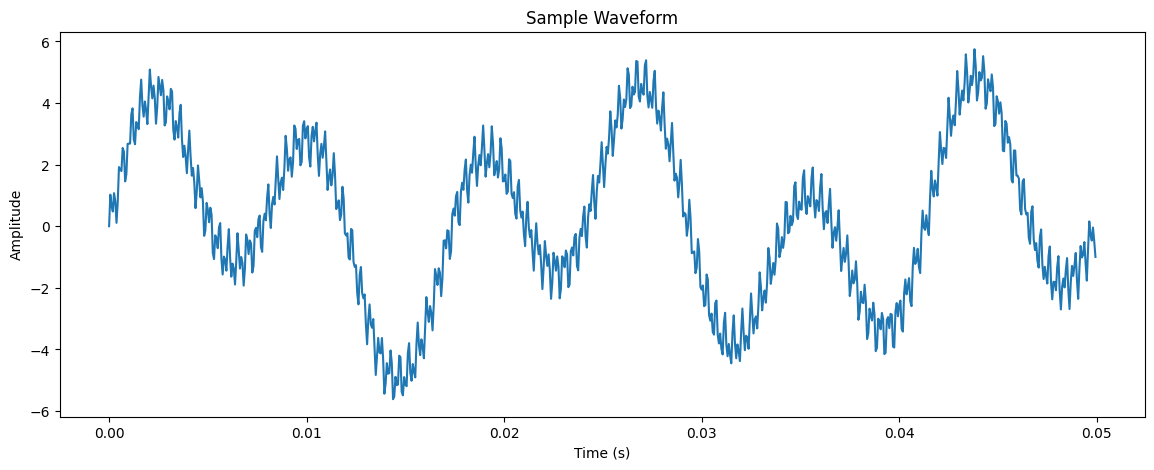

앰플리튜드 스펙트로그램 :  (481, 6)


/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=960 is too large for input signal of length=800
  warnings.warn(


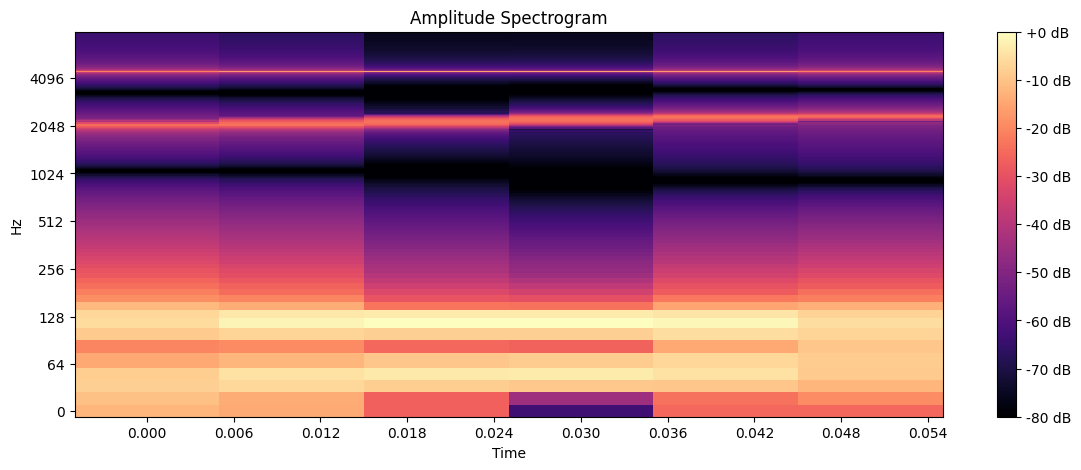

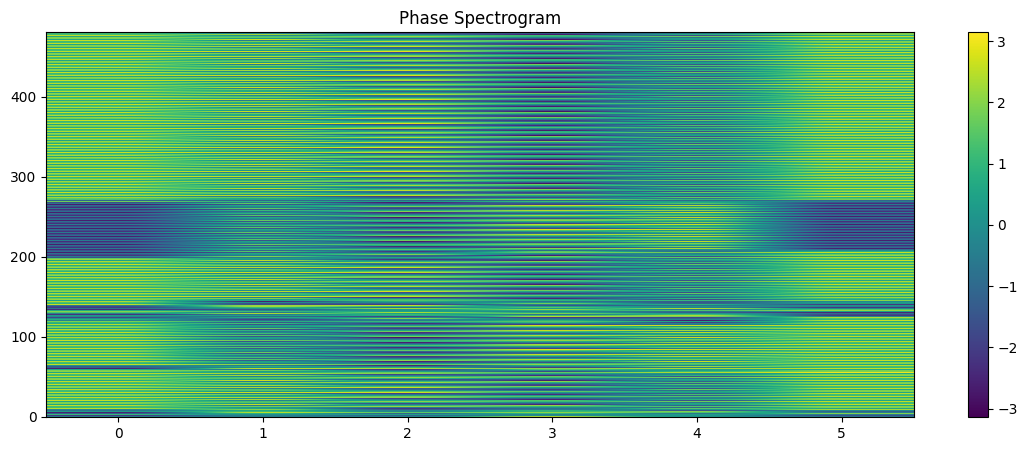

복원된 웨이브 :  (800,)


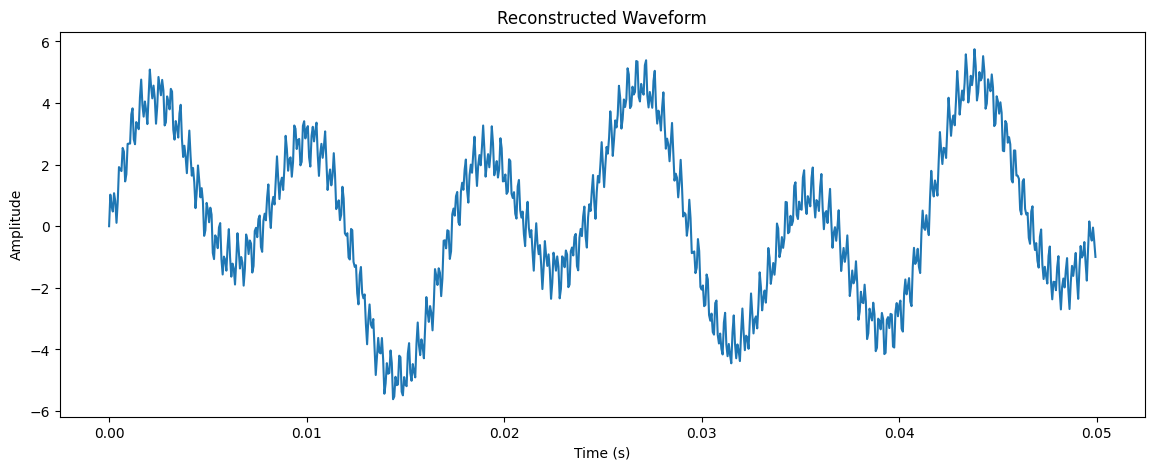

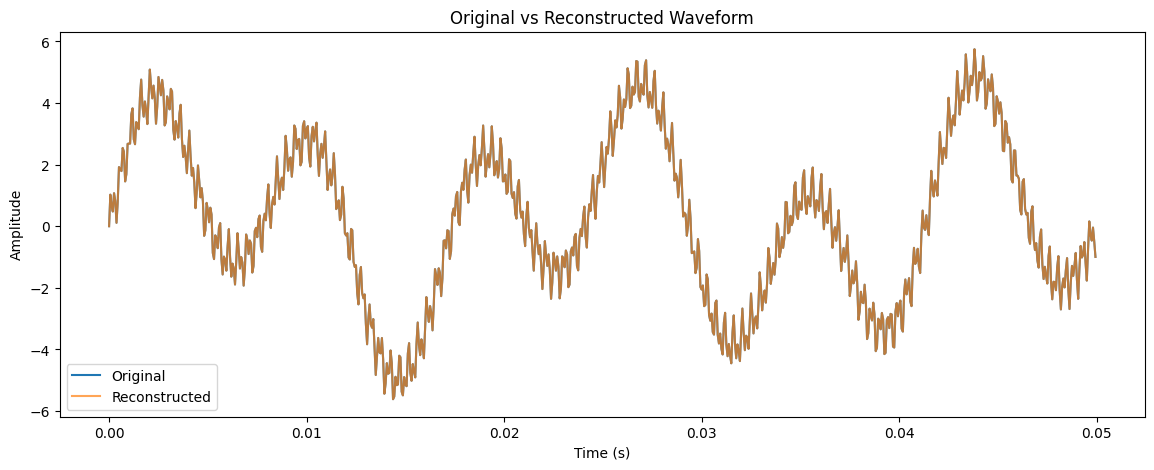

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

# 1. sample_wav 생성 (4초 길이, 샘플레이트 16000)
sr = 16000  # 샘플레이트
duration = 0.05  # 초

t = np.linspace(0, duration, int(sr * duration), endpoint=False)
sample_wav = 2 * np.sin(2 * np.pi * 50 * t) + 3 * np.sin(2 * np.pi * 120 * t) + 0.5 * np.sin(2 * np.pi * (2000*(1-2*t) + 4000*(2*t)) * t)  + 0.5 * np.sin(2 * np.pi * 4500 * t) # 440 Hz 사인파

print("샘플웨이브 : ", sample_wav.shape, f"오디오 {duration} 초")
# 1_2. sample_wav를 plot
plt.figure(figsize=(14, 5))
plt.plot(t, sample_wav)
plt.title("Sample Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# 2. sample_wav를 librosa.stft를 사용해 스펙트로그램 sample_spt 생성
win_length = 960
hop_length = 160
sample_spt = librosa.stft(sample_wav, n_fft=win_length, hop_length=hop_length, win_length=win_length)

# 3. sample_spt의 이미지 스펙트로그램 plot (amplitude 스펙트로그램과 phase 스펙트로그램)
amplitude_spt = np.abs(sample_spt)
phase_spt = np.angle(sample_spt)
print("앰플리튜드 스펙트로그램 : ", amplitude_spt.shape)
plt.figure(figsize=(14, 5))
librosa.display.specshow(librosa.amplitude_to_db(amplitude_spt, ref=np.max), sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
plt.title("Amplitude Spectrogram")
plt.colorbar(format="%+2.0f dB")
plt.show()

plt.figure(figsize=(14, 5))
plt.imshow(phase_spt, aspect='auto', origin='lower')
plt.title("Phase Spectrogram")
plt.colorbar()
plt.show()

# 4. sample_spt를 libroa.istft를 사용해 sample_wav를 복원
reconstructed_wav = librosa.istft(sample_spt, hop_length=hop_length, win_length=win_length)

print("복원된 웨이브 : ", reconstructed_wav.shape)
# 5. 복원한 sample_wav를 plot
plt.figure(figsize=(14, 5))
plt.plot(t, reconstructed_wav)
plt.title("Reconstructed Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# 6. 복원된 sample_wav와 원래 sample_wav 비교
plt.figure(figsize=(14, 5))
plt.plot(t, sample_wav, label='Original')
plt.plot(t, reconstructed_wav, alpha=0.7, label='Reconstructed')
plt.title("Original vs Reconstructed Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


In [2]:
import torch
from torch.nn.utils.rnn import pad_sequence

def loss_function(target, ipt):
        print("clean shape in loss.py : ", ipt.shape) # B x F x T
        print("enhanced shape in loss.py : ", target.shape) # B x F x T
        return torch.nn.functional.mse_loss(target, ipt)
            

In [3]:
import os
import librosa
import numpy as np
import torch

# 파일 경로 설정
label_folder = 'dataset/label'
mixed_folder = 'dataset/mixed'
batch_size = 8
sampling_rate = 16000
audio_length = 4 * sampling_rate  # 4초의 길이

# 파일 리스트 가져오기
label_files = sorted([os.path.join(label_folder, f) for f in os.listdir(label_folder) if f.endswith('.wav')])
mixed_files = sorted([os.path.join(mixed_folder, f) for f in os.listdir(mixed_folder) if f.endswith('.wav')])

# STFT 파라미터 설정
n_fft = 960
hop_length = 160

def load_audio(file_path, sr=sampling_rate):
    y, _ = librosa.load(file_path, sr=sr)
    y = librosa.util.fix_length(y, size=audio_length)  # 길이를 4초로 맞추기
    return y

def compute_stft(y, n_fft=n_fft, hop_length=hop_length):
    stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    amp = np.abs(stft)
    phase = np.angle(stft)
    return amp, phase

# 배치 리스트 초기화
batches_mixed_amp = []
batches_clean_amp = []
batches_mixed_phase = []
batches_clean_phase = []

# 파일을 순차적으로 처리하여 배치로 나누기
for i in range(0, len(label_files), batch_size):
    mixed_amp_list = []
    mixed_phase_list = []
    clean_amp_list = []
    clean_phase_list = []
    
    for j in range(batch_size):
        if i + j >= len(label_files):
            break
            
        label_file = label_files[i + j]
        mixed_file = mixed_files[i + j]
        
        # 오디오 파일 로드
        clean_audio = load_audio(label_file)
        mixed_audio = load_audio(mixed_file)
        
        # STFT 계산
        mixed_amp, mixed_phase = compute_stft(mixed_audio)
        clean_amp, clean_phase = compute_stft(clean_audio)
        
        mixed_amp_list.append(mixed_amp)
        mixed_phase_list.append(mixed_phase)
        clean_amp_list.append(clean_amp)
        clean_phase_list.append(clean_phase)
    
    # 리스트를 넘파이 배열로 변환하고 형태 조정
    mixed_amp_batch = np.array(mixed_amp_list)
    mixed_phase_batch = np.array(mixed_phase_list)
    clean_amp_batch = np.array(clean_amp_list)
    clean_phase_batch = np.array(clean_phase_list)
    
    # 배치를 리스트에 추가
    batches_mixed_amp.append(mixed_amp_batch)
    batches_clean_amp.append(clean_amp_batch)
    batches_mixed_phase.append(mixed_phase_batch)
    batches_clean_phase.append(clean_phase_batch)

# 넘파이 배열 형태로 변환
batches_mixed_amp = np.array(batches_mixed_amp)
batches_clean_amp = np.array(batches_clean_amp)
batches_mixed_phase = np.array(batches_mixed_phase)
batches_clean_phase = np.array(batches_clean_phase)

# 출력 형태 확인
print(f"Mixed Amplitude Batch Shape: {batches_mixed_amp.shape}")  # (10, 16, Frequency Bins, Number of Frames)
print(f"Clean Amplitude Batch Shape: {batches_clean_amp.shape}")  # (10, 16, Frequency Bins, Number of Frames)
print(f"Mixed Phase Batch Shape: {batches_mixed_phase.shape}")    # (10, 16, Frequency Bins, Number of Frames)
print(f"Clean Phase Batch Shape: {batches_clean_phase.shape}")    # (10, 16, Frequency Bins, Number of Frames)


Mixed Amplitude Batch Shape: (20, 8, 481, 401)
Clean Amplitude Batch Shape: (20, 8, 481, 401)
Mixed Phase Batch Shape: (20, 8, 481, 401)
Clean Phase Batch Shape: (20, 8, 481, 401)


In [4]:
import torch
import matplotlib.pyplot as plt



# 모델 초기화
model = CRN().to(device="cuda")

# 옵티마이저
optimizer = torch.optim.Adam(
        params=model.parameters(),
        lr=0.006,
        betas = [0.9, 0.999])


In [5]:
# Put data to target device
device = "cuda"
epochs = 5
batch_mixed = torch.from_numpy(batches_mixed_amp).to(device)
batch_clean = torch.from_numpy(batches_clean_amp).to(device)

for epoch in range(epochs):
    model.train()
    for i in range(20):
        ## Training
        
        # 1. Forward pass
        prediction_amp_spt = model(batch_mixed[i].permute(0,2,1)) # 시간축과 주파수축을 전환
        
        # 2. Calculate loss/accuracy
        prediction_amp_spt = prediction_amp_spt.permute(0,2,1)
        loss = loss_function(prediction_amp_spt, batch_clean[i])
        # 3. Optimizer zero grad
        optimizer.zero_grad()
    
        # 4. Loss backwards
        loss.backward()
    
        # 5. Optimizer step
        optimizer.step()


input : torch.Size([8, 401, 481])
unsqueezed input : torch.Size([8, 1, 401, 481])
Conv1 Output : torch.Size([8, 16, 401, 240])
Conv2 Output : torch.Size([8, 32, 401, 119])
Conv3 Output : torch.Size([8, 64, 401, 59])
Conv4 Output : torch.Size([8, 128, 401, 29])
Conv5 Output : torch.Size([8, 256, 401, 14])
permuted Output : torch.Size([8, 401, 256, 14])
reshaped Output for lstm Input : torch.Size([8, 401, 3584])
lstm output : torch.Size([8, 256, 401, 14])


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608839953/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


concat lstm : torch.Size([8, 512, 401, 14])
deConv1 out : torch.Size([8, 128, 401, 29])
concat deConv1 : torch.Size([8, 256, 401, 29])
deConv2 out : torch.Size([8, 64, 401, 59])
concat deConv2 : torch.Size([8, 128, 401, 59])
deConv3 out : torch.Size([8, 32, 401, 119])
concat deConv3 : torch.Size([8, 64, 401, 119])
deConv4 out : torch.Size([8, 16, 401, 240])
concat deConv4 : torch.Size([8, 32, 401, 240])
deConv5 out : torch.Size([8, 1, 401, 481])
Squeezed deConv5 out : torch.Size([8, 401, 481])
clean shape in loss.py :  torch.Size([8, 481, 401])
enhanced shape in loss.py :  torch.Size([8, 481, 401])


/opt/conda/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608839953/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


input : torch.Size([8, 401, 481])
unsqueezed input : torch.Size([8, 1, 401, 481])
Conv1 Output : torch.Size([8, 16, 401, 240])
Conv2 Output : torch.Size([8, 32, 401, 119])
Conv3 Output : torch.Size([8, 64, 401, 59])
Conv4 Output : torch.Size([8, 128, 401, 29])
Conv5 Output : torch.Size([8, 256, 401, 14])
permuted Output : torch.Size([8, 401, 256, 14])
reshaped Output for lstm Input : torch.Size([8, 401, 3584])
lstm output : torch.Size([8, 256, 401, 14])
concat lstm : torch.Size([8, 512, 401, 14])
deConv1 out : torch.Size([8, 128, 401, 29])
concat deConv1 : torch.Size([8, 256, 401, 29])
deConv2 out : torch.Size([8, 64, 401, 59])
concat deConv2 : torch.Size([8, 128, 401, 59])
deConv3 out : torch.Size([8, 32, 401, 119])
concat deConv3 : torch.Size([8, 64, 401, 119])
deConv4 out : torch.Size([8, 16, 401, 240])
concat deConv4 : torch.Size([8, 32, 401, 240])
deConv5 out : torch.Size([8, 1, 401, 481])
Squeezed deConv5 out : torch.Size([8, 401, 481])
clean shape in loss.py :  torch.Size([8, 48

NameError: name 'sr' is not defined

Epoch: 5 | Loss: 0.33222


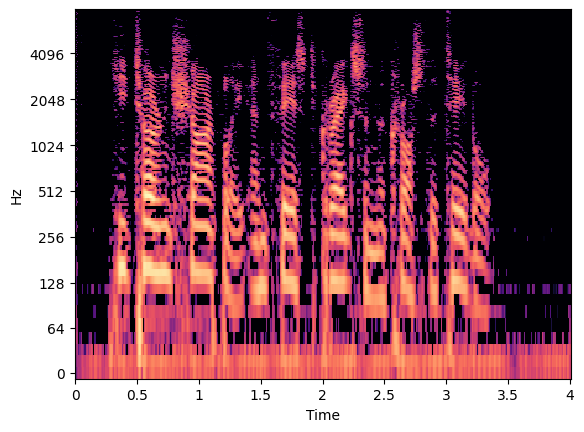

In [9]:
librosa.display.specshow(librosa.amplitude_to_db(prediction_amp_spt[0].detach().cpu().numpy(), ref=np.max), sr=16000, hop_length=hop_length, x_axis='time', y_axis='log')
print(f"Epoch: {epochs} | Loss: {loss:.5f}")

Epoch: 5 | Loss: 0.33222


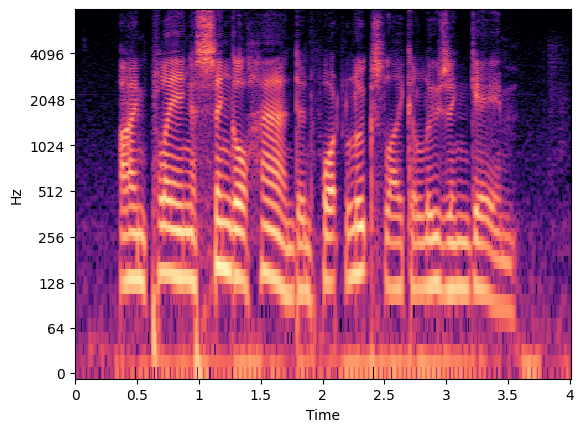

In [10]:
librosa.display.specshow(librosa.amplitude_to_db(batch_clean[0][0].detach().cpu().numpy(), ref=np.max), sr=16000, hop_length=hop_length, x_axis='time', y_axis='log')
print(f"Epoch: {epochs} | Loss: {loss:.5f}")

Epoch: 5 | Loss: 0.33222


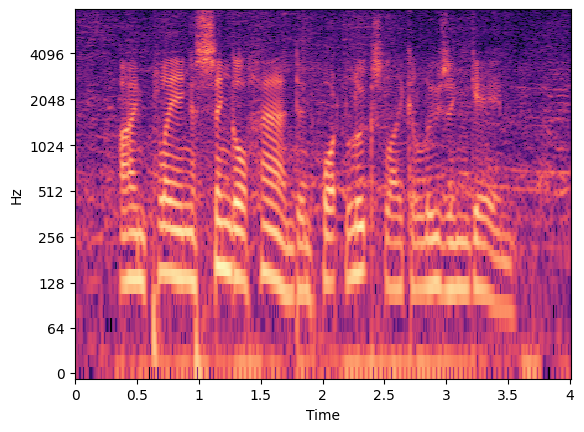

In [11]:
librosa.display.specshow(librosa.amplitude_to_db(batch_mixed[0][0].detach().cpu().numpy(), ref=np.max), sr=16000, hop_length=hop_length, x_axis='time', y_axis='log')
print(f"Epoch: {epochs} | Loss: {loss:.5f}")

In [17]:
import torch
import numpy as np
import librosa
from pesq import pesq
from pesq import PesqError


# Convert STFT back to time-domain signal
def istft(magnitude, phase, n_fft=n_fft, hop_length=hop_length):
    complex_spectrum = magnitude * np.exp(1j * phase)
    y = librosa.istft(complex_spectrum, hop_length=hop_length)
    return y

# Evaluate PESQ score
def evaluate_pesq(model, batch_mixed, batch_clean, device, sampling_rate=sampling_rate):
    model.eval()
    pesq_scores = []

    with torch.no_grad():
        for i in range(1):
            # Forward pass
            mixed_amp_spt = batch_mixed[i]  
            clean_amp_spt = batch_clean[i]  
            prediction_amp_spt = model(mixed_amp_spt.permute(0,2,1)).permute(0, 2, 1).cpu().numpy()  # B x F x T

            # Get the phase of the mixed signal
            mixed_audio = mixed_amp_spt.cpu().numpy()
            mixed_phase = batches_mixed_phase[i]
            for j in range(batch_size):
                # Reconstruct the time-domain signal
                predicted_audio = istft(prediction_amp_spt[j], mixed_phase[j])
                clean_audio = istft(clean_amp_spt[j].cpu().numpy(), batches_clean_phase[0][j])

                try:
                    # Calculate PESQ score
                    pesq_score = pesq(sampling_rate, clean_audio, predicted_audio, mode='wb')
                    pesq_scores.append(pesq_score)
                except PesqError as e:
                    print(f"Error calculating PESQ score: {e}")
                    pesq_scores.append(None)

    return np.array(pesq_scores)

# Put data to target device
device = "cuda"
batch_mixed = torch.from_numpy(batches_mixed_amp).to(device)
batch_clean = torch.from_numpy(batches_clean_amp).to(device)

# Evaluate model using PESQ
pesq_scores = evaluate_pesq(model, batch_mixed, batch_clean, device)
average_pesq = np.mean([score for score in pesq_scores if score is not None])

print(f"Average PESQ score: {average_pesq}")


input : torch.Size([8, 401, 481])
unsqueezed input : torch.Size([8, 1, 401, 481])
Conv1 Output : torch.Size([8, 16, 401, 240])
Conv2 Output : torch.Size([8, 32, 401, 119])
Conv3 Output : torch.Size([8, 64, 401, 59])
Conv4 Output : torch.Size([8, 128, 401, 29])
Conv5 Output : torch.Size([8, 256, 401, 14])
permuted Output : torch.Size([8, 401, 256, 14])
reshaped Output for lstm Input : torch.Size([8, 401, 3584])
lstm output : torch.Size([8, 256, 401, 14])
concat lstm : torch.Size([8, 512, 401, 14])
deConv1 out : torch.Size([8, 128, 401, 29])
concat deConv1 : torch.Size([8, 256, 401, 29])
deConv2 out : torch.Size([8, 64, 401, 59])
concat deConv2 : torch.Size([8, 128, 401, 59])
deConv3 out : torch.Size([8, 32, 401, 119])
concat deConv3 : torch.Size([8, 64, 401, 119])
deConv4 out : torch.Size([8, 16, 401, 240])
concat deConv4 : torch.Size([8, 32, 401, 240])
deConv5 out : torch.Size([8, 1, 401, 481])
Squeezed deConv5 out : torch.Size([8, 401, 481])
Average PESQ score: 4.643888473510742


In [19]:
import torch
import numpy as np
import librosa
import soundfile as sf
import os


batch_mixed = torch.from_numpy(batches_mixed_amp).to(device)
mixed_phase = batches_mixed_phase[0]

for i in range(1):
    model.eval()
    prediction_amp_spt = model(batch_mixed[i].permute(0,2,1)) # 시간축과 주파수축을 전환
    prediction_amp_spt = prediction_amp_spt.permute(0,2,1).cpu().detach().numpy()
    with torch.no_grad():
        for j in range(8):
            # 1. Forward pass
            predicted_audio = istft(prediction_amp_spt[j], mixed_phase[j])
            output_file = f'dataset/enhanced/predicted_audio_{j+1}.wav'
            sf.write(output_file, predicted_audio, samplerate=16000)
            print(f'Saved {output_file}')
            
        
        
        


input : torch.Size([8, 401, 481])
unsqueezed input : torch.Size([8, 1, 401, 481])
Conv1 Output : torch.Size([8, 16, 401, 240])
Conv2 Output : torch.Size([8, 32, 401, 119])
Conv3 Output : torch.Size([8, 64, 401, 59])
Conv4 Output : torch.Size([8, 128, 401, 29])
Conv5 Output : torch.Size([8, 256, 401, 14])
permuted Output : torch.Size([8, 401, 256, 14])
reshaped Output for lstm Input : torch.Size([8, 401, 3584])
lstm output : torch.Size([8, 256, 401, 14])
concat lstm : torch.Size([8, 512, 401, 14])
deConv1 out : torch.Size([8, 128, 401, 29])
concat deConv1 : torch.Size([8, 256, 401, 29])
deConv2 out : torch.Size([8, 64, 401, 59])
concat deConv2 : torch.Size([8, 128, 401, 59])
deConv3 out : torch.Size([8, 32, 401, 119])
concat deConv3 : torch.Size([8, 64, 401, 119])
deConv4 out : torch.Size([8, 16, 401, 240])
concat deConv4 : torch.Size([8, 32, 401, 240])
deConv5 out : torch.Size([8, 1, 401, 481])
Squeezed deConv5 out : torch.Size([8, 401, 481])
Saved dataset/enhanced/predicted_audio_1.wa